In [1]:
"""
Learning growth constants model
===============================

In this example we will learn a growth constants model from a leaf that follows a
basipetal growth pattern.

"""

###############################################################################
# We first import what we need.
#

import sys
sys.path.append("../../")

import math
import pickle
import copy

import numpy as np
import torch
import matplotlib.pyplot as plt

import implicitmodules.torch as dm

###############################################################################
# We load the data, rescale it and zero it.
#
# In order to get more information, we also load the points.
#

In [2]:
# Loading the datasets
try:
    data = pickle.load(open("../../data/data_acropetal.pkl", 'rb'))
except:
    print("Could not load the file.")

pos_source = torch.tensor(data['source_silent']).type(torch.get_default_dtype())
pos_implicit0 = torch.tensor(data['source_implicit0']).type(torch.get_default_dtype())
pos_implicit1 = torch.tensor(data['source_implicit1']).type(torch.get_default_dtype())
pos_target = torch.tensor(data['target_silent']).type(torch.get_default_dtype())

# Some rescaling for the source
Dx = 0.
Dy = 0.
height_source = 90.
height_target = 495.

smin, smax = torch.min(pos_source[:, 1]), torch.max(pos_source[:, 1])
sscale = height_source / (smax - smin)
pos_source[:, 0] = Dx + sscale * (pos_source[:, 0] - torch.mean(pos_source[:, 0]))
pos_source[:, 1] = Dy - sscale * (pos_source[:, 1] - smax)
pos_implicit0[:, 0] = Dx + sscale * (pos_implicit0[:, 0] - torch.mean(pos_implicit0[:, 0]))
pos_implicit0[:, 1] = Dy - sscale * (pos_implicit0[:, 1] - smax)
pos_implicit1[:, 0] = Dx + sscale * (pos_implicit1[:, 0] - torch.mean(pos_implicit1[:, 0]))
pos_implicit1[:, 1] = Dy - sscale * (pos_implicit1[:, 1] - smax)

# Some rescaling for the target
tmin, tmax = torch.min(pos_target[:, 1]), torch.max(pos_target[:, 1])
tscale = height_target / (tmax - tmin)
pos_target[:, 0] = tscale * (pos_target[:, 0] - torch.mean(pos_target[:, 0]))
pos_target[:, 1] = - tscale * (pos_target[:, 1] - tmax)

# Compute an AABB for plotting
aabb = dm.Utilities.AABB.build_from_points(pos_target)
aabb.squared()

In [7]:
data

{'source_img': array([[[232, 232, 232],
         [221, 221, 221],
         [211, 211, 211],
         ...,
         [217, 215, 215],
         [230, 227, 227],
         [240, 237, 237]],
 
        [[203, 203, 203],
         [173, 173, 173],
         [144, 143, 143],
         ...,
         [164, 162, 162],
         [191, 188, 188],
         [214, 212, 212]],
 
        [[167, 166, 166],
         [114, 112, 112],
         [ 60,  58,  58],
         ...,
         [ 98,  97,  97],
         [142, 141, 141],
         [182, 181, 181]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255,

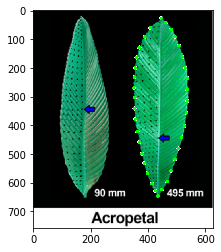

In [6]:
plt.imshow(data['target_img'])